#reema

The first step is to load the dataset. As our dataset is represented as a text file with the format (sentence;emotion), we use the parameter sep=";" as a separator to create a table containing two columns: text for the sentences and label for the emotions. Then, we read the first five elements to ensure that the data has been loaded properly.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("train.txt", sep=";", names=["text", "label"])
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


we using (.info) to get the dataset description:
1- number of features (columns)
2- number of observations (rows)
3- data types


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


from the result we notice:
1- there are 2 columns (0:text and 1:label)
2- there are  16K rows (0-15999)
3- Both coulmns have 16000 non-null entries implies that no missing data
4- Both are of type object (object in pandas means text type) 

in this step we have to anlayze the target class, in our case the label column
we use:
1- df['label'].nunique() to count how many diffren labels 
2- df['label'].unique() list all unique emotion classes
3- df['label'].value_counts() to know how many text for each label

In [6]:
print("there are",df['label'].nunique(),"diffrent classes (emotions):\n",df['label'].unique()) 

there are 6 diffrent classes (emotions):
 ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


In [7]:
df['label'].value_counts()

label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

From the results, we observe that:
1- we have six different emotion classes.
2- The dataset is imbalanced, as some emotions significantly outnumber others (e.g., joy vs surprise).

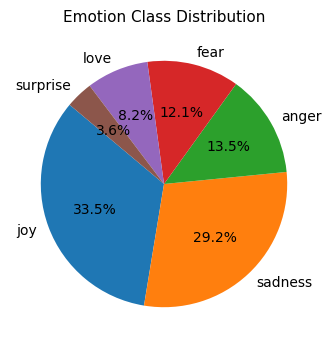

In [21]:
emotionNum = df['label'].value_counts()
plt.figure(figsize=(4,4))
plt.pie(emotionNum,
        labels=emotionNum.index,
        autopct='%1.1f%%',
        startangle=140
        )
plt.title('Emotion Class Distribution', fontsize=11)
plt.show()


In [8]:
df.describe(include=[object])

,text,label
count,16000,16000
unique,15969,6
top,i feel on the verge of tears from weariness i ...,joy
freq,2,5362


In [9]:
df['text'].duplicated().sum()
duplicate_sentences = df[df['text'].duplicated(keep=False)]
duplicate_sentences['text'].unique()

array(['i tend to stop breathing when i m feeling stressed',
       'i feel on the verge of tears from weariness i look at your sweet face and cant help but tenderly kiss your cheeks',
       'i was intensely conscious of how much cash i had left in my gas and food envelope and i still have what i intended to save for next week which helps me not feel so stressed and scared',
       'i still feel completely accepted',
       'im still not sure why reilly feels the need to be so weird',
       'i shy away from songs that talk about how i feel toward god or that maybe even talk about my faithful response toward god',
       'i am not amazing or great at photography but i feel passionate about it',
       'i still feel a craving for sweet food',
       'i often find myself feeling assaulted by a multitude of sense impressions',
       'i had to choose the sleek and smoother feel of the sweet revenge made drawing and handling the blaster a bit nicer',
       'i feel more adventurous willin